In [1]:
"""
callejero.py

Matemática Discreta - IMAT
ICAI, Universidad Pontificia Comillas

Grupo: GP02A
Integrantes:
    - JAVIER ESCOBAR SERRANO
    - ENRIQUE FERNÁNDEZ-BAILLO RODRIÍGUEZ DE TEMBLEQUE

Descripción:
Librería con herramientas y clases auxiliares necesarias para la representación de un callejero en un grafo.

Complétese esta descripción según las funcionalidades agregadas por el grupo.
"""

#Constantes con las velocidades máximas establecidas por el enunciado para cada tipo de vía.
VELOCIDADES_CALLES={"AUTOVIA":100,"AVENIDA":90,"CARRETERA":70,"CALLEJON":30,"CAMINO":30,"ESTACION DE METRO":20,"PASADIZO":20,"PLAZUELA":20,"COLONIA":20}
VELOCIDAD_CALLES_ESTANDAR=50

import pandas as pd
import numpy as np
from dgt import process_data
from grafo import Grafo
from math import sqrt
df_cruces, df_direcc = process_data("data/cruces.csv", "data/direcciones.csv")
df_direcc["coordenadas"] = list(zip(df_direcc["Coordenada X (Guia Urbana) cm"], df_direcc["Coordenada Y (Guia Urbana) cm"]))

class Cruce:

    #Completar esta clase con los datos y métodos que se necesite asociar a cada cruce

    def __init__(self,coord_x,coord_y):
        self.coord_x=coord_x
        self.coord_y=coord_y
        self.calles = self.get_calles(df_cruces)
    
    """Se hace que la clase Cruce sea "hashable" mediante la implementación de los métodos
    __eq__ y __hash__, haciendo que dos objetos de tipo Cruce se consideren iguales cuando
    sus coordenadas coincidan (es decir, C1==C2 si y sólo si C1 y C2 tienen las mismas coordenadas),
    independientemente de los otros campos que puedan estar almacenados en los objetos.
    La función __hash__ se adapta en consecuencia para que sólo dependa del par (coord_x, coord_y).
    """
    def __eq__(self,other) -> int:
        if type(other) is type(self):
            return ((self.coord_x==other.coord_x) and (self.coord_y==other.coord_y))
        else:
            return False
    
    def __hash__(self) -> int:
        return hash((self.coord_x,self.coord_y))

    def get_calles(self, cruces: pd.DataFrame):
        return cruces[cruces["coordenadas"] == (self.coord_x, self.coord_y)]["Codigo de vía tratado"].unique()
    

class Calle:
    #Completar esta clase con los datos que sea necesario almacenar de cada calle para poder reconstruir los datos del callejero
    def __init__(self, ID):
        self.ID = ID
        self.direcciones = self.get_data(df_cruces, df_direcc)[1]
        self.cruces = self.get_data(df_cruces, df_direcc)[0]

    def get_data(self, cruces: pd.DataFrame, direcciones: pd.DataFrame)-> tuple:
        return (cruces[cruces["Codigo de vía tratado"] == self.ID].coordenadas.unique(), direcciones[direcciones["Codigo de via"] == self.ID])

    def get_velocidad(self):
        if self.direcciones.empty or self.direcciones["Clase de la via"].iloc[0] not in VELOCIDADES_CALLES:
            return VELOCIDAD_CALLES_ESTANDAR
        else:
            return VELOCIDADES_CALLES[self.direcciones["Clase de la via"].iloc[0]]
        
    def ordenar_cruces(self):
        if len(self.direcciones.loc[self.direcciones["Prefijo de numeración"] != "KM."]) != 0:
            return
        
        cruces_ordenados = {}

        def funcion_aux(x, cruce):
            if x['Prefijo de numeración'] == "KM.":
                pass
            else:
                distancias[dist(x["coordenadas"], cruce)] = x["Número"]

        for cruce in self.cruces:
            try:
                distancias = {}
                self.direcciones.apply(lambda x: funcion_aux(x, cruce), axis=1)
                distancias = dict(sorted(distancias.items()))
                
                distancias_lista = list(distancias.keys())
                distancia_min = distancias_lista[0]
                num_dist_min = distancias[distancia_min]
                
                while num_dist_min % 2 == 0:
                    distancias_lista.pop(0)
                    distancia_min = distancias_lista[0]
                    num_dist_min = distancias[distancia_min]

                if num_dist_min not in cruces_ordenados:
                    cruces_ordenados[num_dist_min] = cruce
                
                else:
                    num_anterior = num_dist_min - 2
                    num_siguiente = num_dist_min + 2
                    
                    while num_dist_min + 0.01 in cruces_ordenados:
                        num_dist_min += 0.01
                    
                    error = True
                    while error:
                        try:
                            coords_anterior = self.direcciones.loc[self.direcciones["Número"] == num_anterior]['coordenadas'].values[0]
                            cruce_anterior = cruces_ordenados[num_dist_min]

                            dist_cruce_actual = dist(cruce, coords_anterior)
                            dist_cruce_anterior = dist(cruce_anterior, coords_anterior)
                            
                            if dist_cruce_actual < dist_cruce_anterior:
                                cruces_ordenados[num_dist_min + 0.01] = cruce_anterior
                                cruces_ordenados[num_dist_min] = cruce
                            else:
                                cruces_ordenados[num_dist_min + 0.01] = cruce
                            error = False

                        except:
                            try:
                                coords_siguiente = self.direcciones.loc[self.direcciones["Número"] == num_siguiente]['coordenadas'].values[0]
                                cruce_anterior = cruces_ordenados[num_dist_min]

                                dist_cruce_actual = dist(cruce, coords_siguiente)
                                dist_cruce_siguiente = dist(cruce_anterior, coords_siguiente)

                                if dist_cruce_actual < dist_cruce_siguiente:
                                    cruces_ordenados[num_dist_min + 0.01] = cruce
                                else:
                                    cruces_ordenados[num_dist_min + 0.01] = cruce_anterior
                                    cruces_ordenados[num_dist_min] = cruce
                                error = False
                            except:
                                num_siguiente += 2
            except:
                continue
        
        cruces_ordenados = dict(sorted(cruces_ordenados.items()))
        cruces_ordenados = list(cruces_ordenados.values())
        self.cruces = cruces_ordenados

def filtrar_por_radios(R: int):
    df_cruces["coordenadas"] = list(zip(df_cruces["Coordenada X (Guia Urbana) cm (cruce)"], df_cruces["Coordenada Y (Guia Urbana) cm (cruce)"]))
    coordenadas_a_tratar = sorted(df_cruces["coordenadas"].unique())
    coordenadas_limpias = []
    for coordenada in coordenadas_a_tratar:
        for x, y in coordenadas_limpias:
            if dist(coordenada, (x, y)) <= R:
                break
        else:
            coordenadas_limpias.append(coordenada)

    df_cruces["coordenadas"] = df_cruces["coordenadas"].apply(lambda x: x if x in coordenadas_limpias else closest(x, coordenadas_limpias, R))
    return coordenadas_limpias

def dist(coordenada1, coordenada2):
    return sqrt((coordenada1[0] - coordenada2[0])**2 + (coordenada1[1] - coordenada2[1])**2)

def closest(coordenada, coordenadas_limpias, R):
    coor_x, coor_y = coordenada[0], coordenada[1]
    for x, y in coordenadas_limpias:
        if (coor_x - R <= x <= coor_x + R) and (coor_y - R <= y <= coor_y + R):
            return (x, y)

if __name__ == "__main__":
    from time import time
    coordenadas_limpias = filtrar_por_radios(1500) # 8000 centímetros = 80 metros, se considera que un cruce está dentro del radio de otro si está a menos de 80 metros de distancia según las observaciones
    print(len(coordenadas_limpias))
    print(df_cruces["coordenadas"].head())

    # Creamos los cruces
    cruces = {}
    for coordenada in coordenadas_limpias:
        cruces[coordenada] = Cruce(coordenada[0], coordenada[1])
    list_cruces:list[Cruce] = list(cruces.values())

    # Creamos las calles
    calles = []
    for cruce in list_cruces: # Escogemos los cruces
        for calle in cruce.calles: # Escogemos las calles de cada cruce
            if calle not in calles: # Si la calle no está en la lista de calles, la añadimos
                calles.append(calle)  
    calles = [Calle(calle) for calle in calles] # Creamos los objetos calle

    # Creamos el grafo  
    grafo = Grafo(False)

    # Añadir vértices al grafo
    for cruce in list_cruces:
        grafo.agregar_vertice(cruce)
    
    # Para las aristas, se añaden las calles que conectan dos cruces como aristas del grafo
    for calle in calles:
        calle.ordenar_cruces()
        cruces_calle = calle.cruces
        for i in range(len(cruces_calle)):
            if i != len(cruces_calle) - 1:
                grafo.agregar_arista(cruces[cruces_calle[i]], cruces[cruces_calle[i+1]], None, calle.get_velocidad())

    # Pasemoslo a networkx
    import networkx as nx
    import matplotlib.pyplot as plt
    G = grafo.convertir_a_NetworkX()

    pos = {}
    for cruce in list_cruces:
        pos[cruce] = (cruce.coord_x, cruce.coord_y)

c:\unibersida\segundo\discreta\practica1\Practica_3\dgt.py:40: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(path, encoding="iso-8859-1", delimiter=";")
c:\unibersida\segundo\discreta\practica1\Practica_3\dgt.py:108: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  literal_splitted[columnas] = literal_splitted['Literal de numeracion'].apply(lambda x: pd.Series(listas(x)))


13421
0    (44260732, 448479748)
1    (44260732, 448479748)
2    (44290433, 448494484)
3    (44320997, 448510385)
4    (44322285, 448530840)
Name: coordenadas, dtype: object


In [2]:
df_direcc.iloc[12279]["Nombre de la vía"]

'AMERICA'

In [7]:
df_direcc_filtrado = df_direcc.copy()
df_direcc_filtrado = df_direcc_filtrado[(df_direcc_filtrado["Clase de la via"] == "AVENIDA")]
df_direcc_filtrado = df_direcc_filtrado[(df_direcc_filtrado["Nombre de la vía"] == 'AMERICA')]
df_direcc_filtrado = df_direcc_filtrado[(df_direcc_filtrado["Número"] == 50)]
df_direcc_filtrado

,Codigo de numero,Codigo de via,Clase de la via,Partícula de la vía,Nombre de la vía,Literal de numeracion,Codigo de distrito,Nombre del distrito,Codigo de barrio,Nombre del barrio,...,Tipo de la via a la que pertenece el numero,Situacion de la via respecto al terreno,Tipo de denominacion de la via,Parcela catastral del numero,Tipologia del numero,Zona de valor del numero,Prefijo de numeración,Número,Sufijo de numeración,coordenadas
12279,11017942,42500,AVENIDA,DE,AMERICA,NUM000050,4,SALAMANCA,4,GUINDALERA,...,Vía,Nivel,Pleno,3772907VK4737B,Portal,R14AE,NUM,50,None,"(44372814, 447725231)"


In [35]:
import re
regex_direcciones = r"([A-ZÁÉÍÓÚÜ]+)\s*(DEL|DE LA|DE LOS|DE LAS|DE)?\s+([A-ZÁÉÍÓÚÜ]-[0-9]+|[A-ZÁÉÍÓÚÜ\s]+),?\s+(NUM|KM)?\s?([0-9]+)([A-Z]{0,2})"
origen = "aVEnida de América, 50".upper()
# Sustituir los caracteres con tilde en origen por caracteres sin tilde
origen = origen.replace("Á", "A").replace("É", "E").replace("Í", "I").replace("Ó", "O").replace("Ú", "U").replace("Ü", "U")
print(origen)
clase = re.search(regex_direcciones, origen).group(1)
nombre = re.search(regex_direcciones, origen).group(3)
numero = re.search(regex_direcciones, origen).group(5)
sufijo = re.search(regex_direcciones, origen).group(6)
print(clase)
print(nombre)
print(numero)
if not sufijo:
    print("poya")

AVENIDA DE AMERICA, 50
AVENIDA
AMERICA
50
poya


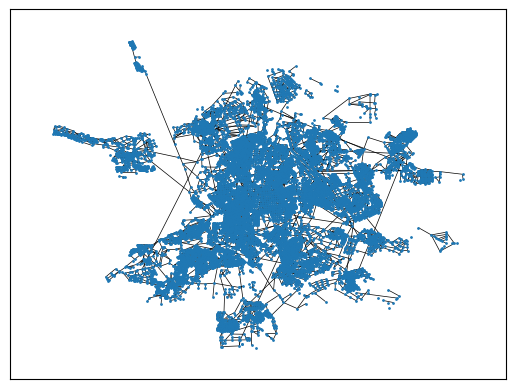

{<__main__.Cruce at 0x2811bc5f6d0>: {<__main__.Cruce at 0x2811bc14ed0>: (None,
   50),
  <__main__.Cruce at 0x2811bbdd090>: (None, 50)},
 <__main__.Cruce at 0x2811bbdd090>: {<__main__.Cruce at 0x2811bc5f6d0>: (None,
   50),
  <__main__.Cruce at 0x2811bc44c50>: (None, 50),
  <__main__.Cruce at 0x2811ba25510>: (None, 50)},
 <__main__.Cruce at 0x2811bb01190>: {<__main__.Cruce at 0x2811ba23d90>: (None,
   50),
  <__main__.Cruce at 0x2811bbf9810>: (None, 50),
  <__main__.Cruce at 0x2811baa2a90>: (None, 50)},
 <__main__.Cruce at 0x2811bc44c50>: {<__main__.Cruce at 0x2811bbdd090>: (None,
   50),
  <__main__.Cruce at 0x2811bc42310>: (None, 50),
  <__main__.Cruce at 0x2811bb87ed0>: (None, 50)},
 <__main__.Cruce at 0x2811bc42310>: {<__main__.Cruce at 0x2811bc44c50>: (None,
   50),
  <__main__.Cruce at 0x2811b979010>: (None, 50),
  <__main__.Cruce at 0x2811b8e5b10>: (None, 50)},
 <__main__.Cruce at 0x2811bbf9810>: {<__main__.Cruce at 0x2811bb01190>: (None,
   50),
  <__main__.Cruce at 0x2811ba23d

In [27]:
nx.draw_networkx_nodes(G, pos=pos, node_size=1)
nx.draw_networkx_edges(G, pos=pos, width=0.5, edge_color="black")
plt.show()
grafo.adyacencia

In [15]:
import numpy as np
df_direcc["coordenadas"] = list(zip(df_direcc["Coordenada X (Guia Urbana) cm"], df_direcc["Coordenada Y (Guia Urbana) cm"]))
calle_ejemplo = Calle(244400)
df_direcc.loc[df_direcc["Codigo de via"] == calle_ejemplo.ID]
cruces_ordenados = {}
print(calle_ejemplo.cruces)

def funcion_aux(df, cruce):
    distancias[dist(cruce, df["coordenadas"])] = df["Número"]

for cruce in calle_ejemplo.cruces:
    try:
        distancias = {}
        calle_ejemplo.direcciones.apply(lambda x: funcion_aux(x, cruce), axis=1)
        distancias = dict(sorted(distancias.items()))
        print("\n", distancias)
        distancias_lista = list(distancias.keys())
        distancia_min = distancias_lista[0]
        num_dist_min = distancias[distancia_min]
        while num_dist_min % 2 == 0:
            distancias_lista.remove(distancia_min)
            distancia_min = distancias_lista[0]
            num_dist_min = distancias[distancia_min]
        while num_dist_min in cruces_ordenados:
            num_dist_min += 0.0001
        cruces_ordenados[num_dist_min] = cruce
    except:
        continue

cruces_ordenados = dict(sorted(cruces_ordenados.items()))
print(cruces_ordenados)
cruces_ordenados = list(cruces_ordenados.values())
calle_ejemplo.cruces = cruces_ordenados
len(calle_ejemplo.cruces)

[(44364643, 447216007) (44369444, 447224618) (44370497, 447226773)
 (44371890, 447229624) (44374030, 447234056) (44375293, 447236796)
 (44377233, 447240796) (44380642, 447247747) (44382265, 447251146)
 (44384514, 447255861) (44388034, 447263463) (44389465, 447267131)
 (44391177, 447271131)]

 {2808.3698118303437: 2, 3254.383505366262: 1, 4909.718627375707: 3, 5204.016237484276: 2, 7250.20944525053: 4, 7851.360391677355: 5, 8200.497362965249: 7, 8795.948214945334: 6, 9102.28674564804: 9, 11411.59384135275: 8, 11874.878904645722: 11, 13278.235914457915: 10, 14229.240387315129: 13, 14271.313114076083: 12, 16793.64760854532: 14, 19235.559388798654: 25, 19404.10910090953: 16, 21076.66446570709: 27, 22117.603599847793: 18, 22196.52387199401: 29, 23726.258069910644: 20, 25524.495058668643: 35, 26127.883745148592: 22, 28828.227347514796: 24, 29936.79383300757: 28, 30387.935402063762: 43, 30723.475877576093: 30, 31434.532683022346: 30, 33810.26648815416: 32, 33945.06039175656: 47, 34595.6591785

13

In [25]:
import numpy as np
df_direcc["coordenadas"] = list(zip(df_direcc["Coordenada X (Guia Urbana) cm"], df_direcc["Coordenada Y (Guia Urbana) cm"]))
calle_ejemplo = Calle(570400)
# calle_ejemplo = Calle(244400)
df_direcc.loc[df_direcc["Codigo de via"] == calle_ejemplo.ID]
cruces_ordenados = {}
print(calle_ejemplo.cruces)

def funcion_aux(df, cruce):
    if df['Prefijo de numeración'] == "KM.":
        pass
    else:
        distancias[dist(cruce, df["coordenadas"])] = df["Número"]

for cruce in calle_ejemplo.cruces:
    try:
        if len(calle_ejemplo.direcciones.loc[calle_ejemplo.direcciones["Prefijo de numeración"] != "KM."]) != 0:
            distancias = {}
            calle_ejemplo.direcciones.apply(lambda x: funcion_aux(x, cruce), axis=1)
            distancias = dict(sorted(distancias.items()))
            
            distancias_lista = list(distancias.keys())
            distancia_min = distancias_lista[0]
            num_dist_min = distancias[distancia_min]
            
            while num_dist_min % 2 == 0:
                distancias_lista.pop(0)
                distancia_min = distancias_lista[0]
                num_dist_min = distancias[distancia_min]
        else:
            break

        if num_dist_min not in cruces_ordenados:
            cruces_ordenados[num_dist_min] = cruce
        
        else:
            num_anterior = num_dist_min - 2
            num_siguiente = num_dist_min + 2
            
            while num_dist_min + 0.01 in cruces_ordenados:
                num_dist_min += 0.01
            
            error = True
            while error:
                try:
                    coords_anterior = calle_ejemplo.direcciones.loc[calle_ejemplo.direcciones["Número"] == num_anterior]['coordenadas'].values[0]
                    cruce_anterior = cruces_ordenados[num_dist_min]

                    dist_cruce_actual = dist(cruce, coords_anterior)
                    dist_cruce_anterior = dist(cruce_anterior, coords_anterior)
                    
                    if dist_cruce_actual < dist_cruce_anterior:
                        cruces_ordenados[num_dist_min + 0.01] = cruce_anterior
                        cruces_ordenados[num_dist_min] = cruce
                    else:
                        cruces_ordenados[num_dist_min + 0.01] = cruce
                    error = False

                except:
                    try:
                        coords_siguiente = calle_ejemplo.direcciones.loc[calle_ejemplo.direcciones["Número"] == num_siguiente]['coordenadas'].values[0]
                        cruce_anterior = cruces_ordenados[num_dist_min]

                        dist_cruce_actual = dist(cruce, coords_siguiente)
                        dist_cruce_siguiente = dist(cruce_anterior, coords_siguiente)

                        if dist_cruce_actual < dist_cruce_siguiente:
                            cruces_ordenados[num_dist_min + 0.01] = cruce
                        else:
                            cruces_ordenados[num_dist_min + 0.01] = cruce_anterior
                            cruces_ordenados[num_dist_min] = cruce
                        error = False
                    except:
                        num_siguiente += 2
    except:
        continue

else:
    cruces_ordenados = dict(sorted(cruces_ordenados.items()))
    print(cruces_ordenados)
    cruces_ordenados = list(cruces_ordenados.values())
    calle_ejemplo.cruces = cruces_ordenados
    len(calle_ejemplo.cruces)


print(calle_ejemplo.cruces)
print(len(calle_ejemplo.direcciones))

[(44180759, 447074073) (44248871, 447151914) (44330498, 447239859)
 (44346861, 447274224) (44364621, 447327385) (44387310, 447378751)
 (44423225, 447462635) (44421630, 447463326) (44417762, 447495373)
 (44419786, 447495915) (44404294, 447605751) (44410872, 447633946)
 (44413181, 447646963) (44411349, 447647426) (44415504, 447660388)
 (44417394, 447682752) (44420641, 447710280) (44418677, 447710323)
 (44389382, 447742866) (44410614, 447832912) (44391008, 447848310)
 (44359715, 447967986) (44323931, 448039966) (44298980, 448134587)
 (44299644, 448150355) (44382333, 448179484)]
[(44180759, 447074073) (44248871, 447151914) (44330498, 447239859)
 (44346861, 447274224) (44364621, 447327385) (44387310, 447378751)
 (44423225, 447462635) (44421630, 447463326) (44417762, 447495373)
 (44419786, 447495915) (44404294, 447605751) (44410872, 447633946)
 (44413181, 447646963) (44411349, 447647426) (44415504, 447660388)
 (44417394, 447682752) (44420641, 447710280) (44418677, 447710323)
 (44389382, 4477